 **GTD TERRORISM DATA MINING PROJECT
Complete Modular Pipeline - Part 1: Setup, EDA & Visualization**

Objectives:
1. Attack Type Classification

Team Members: Rimsha Mahmood, Huma Ejaz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("="*80)
print("GTD TERRORISM DATA MINING PROJECT - COMPLETE PIPELINE")
print("="*80)
print("\nAll libraries imported successfully!\n")

GTD TERRORISM DATA MINING PROJECT - COMPLETE PIPELINE

All libraries imported successfully!



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### BLOCK 1: DATA LOADING & INITIAL EXPLORATION

In [ ]:
filepath = '/content/drive/MyDrive/dataset_2/dataset/GDT/globalterrorismdb_0522dist.xlsx'

In [ ]:
def load_gtd_data(filepath):
    """
    Load GTD dataset and perform initial data quality checks

    Parameters:
    -----------
    filepath : str
        Path to GTD file

    Returns:
    --------
    df : DataFrame
        Loaded dataset
    """
    print("\n" + "="*80)
    print("BLOCK 1: DATA LOADING & INITIAL EXPLORATION")
    print("="*80)

    try:
        df = pd.read_excel(filepath)
        print(f"Dataset loaded successfully!")
        print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

In [ ]:
def initial_data_profile(df):
    """
    Generate comprehensive initial data profile
    """
    print("\nINITIAL DATA PROFILE")
    print("-" * 80)

    # Basic info
    print(f"Dataset Period: {df['iyear'].min()} - {df['iyear'].max()}")
    print(f"Total Incidents: {len(df):,}")
    print(f"Total Features: {len(df.columns)}")

    # Missing values summary
    print("\nMissing Values Summary:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percentage': missing_pct
    }).sort_values('Missing_Percentage', ascending=False)

    print(missing_df[missing_df['Missing_Count'] > 0].head(15))

    # Data types
    print("\nData Types Distribution:")
    print(df.dtypes.value_counts())

    return missing_df

#### BLOCK 2: COMPREHENSIVE EDA & VISUALIZATIONS

In [ ]:
def eda_temporal_analysis(df, save_plots=True):
    """
    Temporal analysis: trends over years, months, quarters
    """
    print("\n" + "="*80)
    print("BLOCK 2A: TEMPORAL ANALYSIS")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Attacks per year
    yearly = df.groupby('iyear').size()
    axes[0, 0].plot(yearly.index, yearly.values, marker='o', linewidth=2, color='darkred')
    axes[0, 0].set_title('Terrorist Attacks Over Years', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Number of Attacks')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Attacks per month
    monthly = df.groupby('imonth').size()
    axes[0, 1].bar(monthly.index, monthly.values, color='steelblue', edgecolor='black')
    axes[0, 1].set_title('Attacks by Month', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Number of Attacks')
    axes[0, 1].set_xticks(range(1, 13))

    # 3. Casualties over time
    yearly_casualties = df.groupby('iyear')[['nkill', 'nwound']].sum().fillna(0)
    axes[1, 0].plot(yearly_casualties.index, yearly_casualties['nkill'],
                    marker='o', label='Killed', linewidth=2, color='red')
    axes[1, 0].plot(yearly_casualties.index, yearly_casualties['nwound'],
                    marker='s', label='Wounded', linewidth=2, color='orange')
    axes[1, 0].set_title('Casualties Over Time', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Number of People')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Day of week pattern (if available)
    if 'iday' in df.columns:
        dow_mapping = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
        # Create day of week from date
        df_temp = df.copy()
        df_temp['dow'] = pd.to_datetime(
            df_temp[['iyear', 'imonth', 'iday']].rename(
                columns={'iyear': 'year', 'imonth': 'month', 'iday': 'day'}
            ), errors='coerce'
        ).dt.dayofweek
        dow_counts = df_temp['dow'].value_counts().sort_index()
        axes[1, 1].bar(range(7), [dow_counts.get(i, 0) for i in range(7)],
                       color='teal', edgecolor='black')
        axes[1, 1].set_title('Attacks by Day of Week', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Day of Week')
        axes[1, 1].set_ylabel('Number of Attacks')
        axes[1, 1].set_xticks(range(7))
        axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    plt.tight_layout()
    if save_plots:
        plt.savefig('eda_temporal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Temporal analysis completed and visualized")

In [ ]:
def eda_attack_type_analysis(df, save_plots=True):
    """
    Attack type distribution and characteristics
    """
    print("\n" + "="*80)
    print("BLOCK 2B: ATTACK TYPE ANALYSIS")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Attack type distribution
    attack_counts = df['attacktype1_txt'].value_counts()
    axes[0, 0].barh(attack_counts.index, attack_counts.values, color='coral', edgecolor='black')
    axes[0, 0].set_title('Distribution of Attack Types', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Incidents')
    axes[0, 0].invert_yaxis()

    # 2. Attack type success rate
    success_rate = df.groupby('attacktype1_txt')['success'].mean() * 100
    success_rate = success_rate.sort_values(ascending=False)
    axes[0, 1].barh(success_rate.index, success_rate.values, color='green', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Success Rate by Attack Type (%)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Success Rate (%)')
    axes[0, 1].invert_yaxis()

    # 3. Casualties by attack type
    casualty_by_type = df.groupby('attacktype1_txt')[['nkill', 'nwound']].sum().fillna(0)
    casualty_by_type = casualty_by_type.sort_values('nkill', ascending=True)

    x = np.arange(len(casualty_by_type))
    width = 0.35
    axes[1, 0].barh(x - width/2, casualty_by_type['nkill'], width,
                    label='Killed', color='darkred', edgecolor='black')
    axes[1, 0].barh(x + width/2, casualty_by_type['nwound'], width,
                    label='Wounded', color='orange', edgecolor='black')
    axes[1, 0].set_yticks(x)
    axes[1, 0].set_yticklabels(casualty_by_type.index)
    axes[1, 0].set_title('Total Casualties by Attack Type', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Number of People')
    axes[1, 0].legend()

    # 4. Attack type trends over time (top 5)
    top_5_attacks = attack_counts.head(5).index
    attack_trends = df[df['attacktype1_txt'].isin(top_5_attacks)].groupby(
        ['iyear', 'attacktype1_txt']
    ).size().unstack(fill_value=0)

    for col in attack_trends.columns:
        axes[1, 1].plot(attack_trends.index, attack_trends[col], marker='o', label=col, linewidth=2)
    axes[1, 1].set_title('Top 5 Attack Types Over Time', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Number of Attacks')
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_plots:
        plt.savefig('eda_attack_type_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Attack type analysis completed and visualized")
    print(f"\nAttack Type Distribution:")
    print(attack_counts)

In [ ]:
def eda_geographic_analysis(df, save_plots=True):
    """
    Geographic hotspot analysis
    """
    print("\n" + "="*80)
    print("BLOCK 2C: GEOGRAPHIC HOTSPOT ANALYSIS")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Top regions
    region_counts = df['region_txt'].value_counts().head(10)
    axes[0, 0].barh(region_counts.index, region_counts.values, color='purple', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Top 10 Regions by Attack Frequency', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Attacks')
    axes[0, 0].invert_yaxis()

    # 2. Top countries
    country_counts = df['country_txt'].value_counts().head(15)
    axes[0, 1].barh(country_counts.index, country_counts.values, color='darkblue', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Top 15 Countries by Attack Frequency', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Attacks')
    axes[0, 1].invert_yaxis()

    # 3. Regional casualties
    regional_casualties = df.groupby('region_txt')[['nkill', 'nwound']].sum().fillna(0)
    regional_casualties = regional_casualties.sort_values('nkill', ascending=True).tail(10)

    x = np.arange(len(regional_casualties))
    width = 0.35
    axes[1, 0].barh(x - width/2, regional_casualties['nkill'], width,
                    label='Killed', color='darkred', edgecolor='black')
    axes[1, 0].barh(x + width/2, regional_casualties['nwound'], width,
                    label='Wounded', color='orange', edgecolor='black')
    axes[1, 0].set_yticks(x)
    axes[1, 0].set_yticklabels(regional_casualties.index)
    axes[1, 0].set_title('Casualties by Region (Top 10)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Number of People')
    axes[1, 0].legend()

    # 4. Hotspot intensity over time (top 5 countries)
    top_5_countries = country_counts.head(5).index
    country_trends = df[df['country_txt'].isin(top_5_countries)].groupby(
        ['iyear', 'country_txt']
    ).size().unstack(fill_value=0)

    for col in country_trends.columns:
        axes[1, 1].plot(country_trends.index, country_trends[col], marker='o', label=col, linewidth=2)
    axes[1, 1].set_title('Top 5 Country Hotspots Over Time', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Number of Attacks')
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_plots:
        plt.savefig('eda_geographic_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Geographic analysis completed and visualized")
    print(f"\nTop 10 Countries:")
    print(country_counts.head(10))


In [ ]:
def eda_correlation_analysis(df, features, save_plots=True):
    """
    Correlation analysis for numerical features
    """
    print("\n" + "="*80)
    print("BLOCK 2D: CORRELATION ANALYSIS")
    print("="*80)

    # Select numerical features
    numerical_cols = df[features].select_dtypes(include=[np.number]).columns
    corr_matrix = df[numerical_cols].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_plots:
        plt.savefig('eda_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Correlation analysis completed and visualized")

In [ ]:
def eda_target_class_balance(df, target_col='attacktype1_txt', save_plots=True):
    """
    Analyze class balance for target variable
    """
    print("\n" + "="*80)
    print("BLOCK 2E: TARGET CLASS BALANCE ANALYSIS")
    print("="*80)

    class_counts = df[target_col].value_counts()
    class_pct = (class_counts / len(df)) * 100

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Count plot
    axes[0].bar(range(len(class_counts)), class_counts.values,
                color=sns.color_palette("husl", len(class_counts)), edgecolor='black')
    axes[0].set_xticks(range(len(class_counts)))
    axes[0].set_xticklabels(class_counts.index, rotation=45, ha='right')
    axes[0].set_title('Class Distribution (Counts)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Samples')
    axes[0].grid(axis='y', alpha=0.3)

    # Percentage plot
    axes[1].bar(range(len(class_pct)), class_pct.values,
                color=sns.color_palette("husl", len(class_pct)), edgecolor='black')
    axes[1].set_xticks(range(len(class_pct)))
    axes[1].set_xticklabels(class_pct.index, rotation=45, ha='right')
    axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Percentage (%)')
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    if save_plots:
        plt.savefig('eda_class_balance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Class balance analysis completed")
    print(f"\nClass Distribution:")
    print(pd.DataFrame({'Count': class_counts, 'Percentage': class_pct}))

    # Imbalance ratio
    max_class = class_counts.max()
    min_class = class_counts.min()
    imbalance_ratio = max_class / min_class
    print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1 (Max class / Min class)")
    if imbalance_ratio > 10:
        print("-> Severe imbalance detected! SMOTE recommended.")

#### Main


BLOCK 1: DATA LOADING & INITIAL EXPLORATION
Dataset loaded successfully!
   Shape: 209,706 rows × 135 columns

INITIAL DATA PROFILE
--------------------------------------------------------------------------------
Dataset Period: 1970 - 2020
Total Incidents: 209,706
Total Features: 135

Missing Values Summary:
                  Missing_Count  Missing_Percentage
gsubname3                209683           99.989032
weapsubtype4             209636           99.966620
weapsubtype4_txt         209636           99.966620
weaptype4_txt            209633           99.965189
weaptype4                209633           99.965189
claimmode3               209566           99.933240
claimmode3_txt           209566           99.933240
gsubname2                209522           99.912258
divert                   209368           99.838822
claim3                   209297           99.804965
guncertain3              209296           99.804488
gname3                   209292           99.802581
ransomnote  

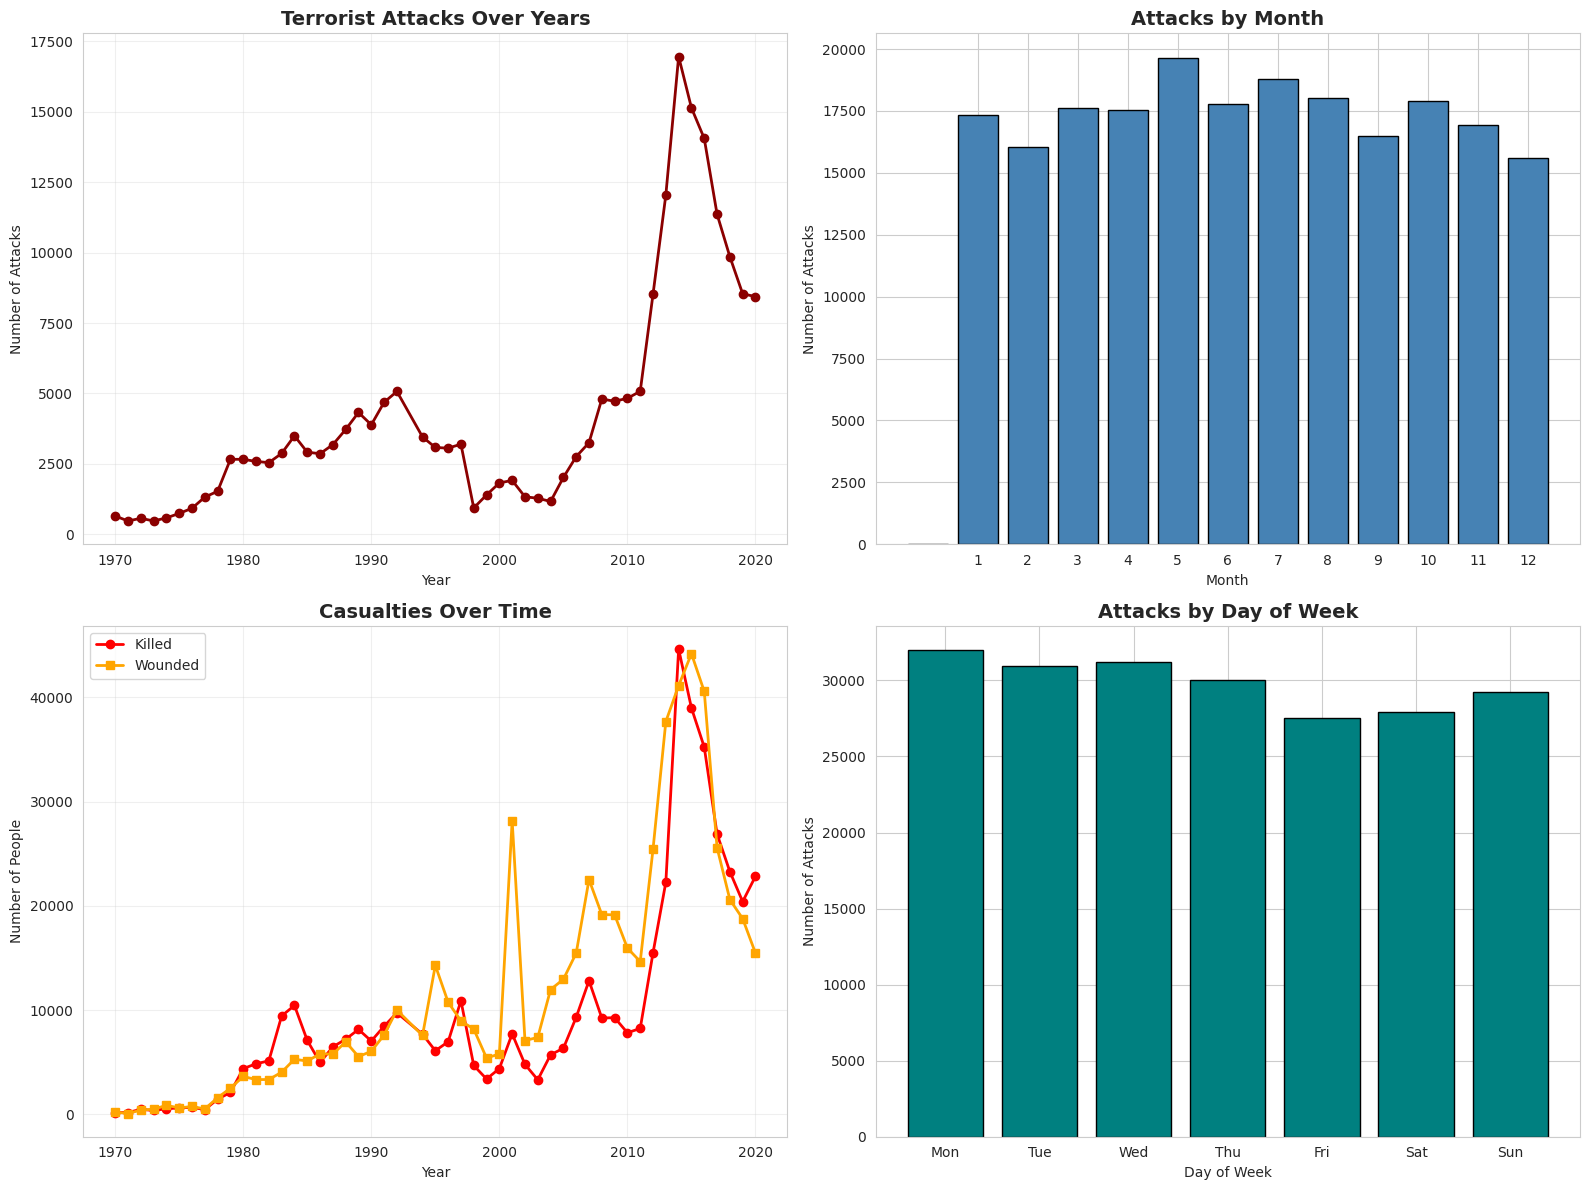

Temporal analysis completed and visualized

BLOCK 2B: ATTACK TYPE ANALYSIS


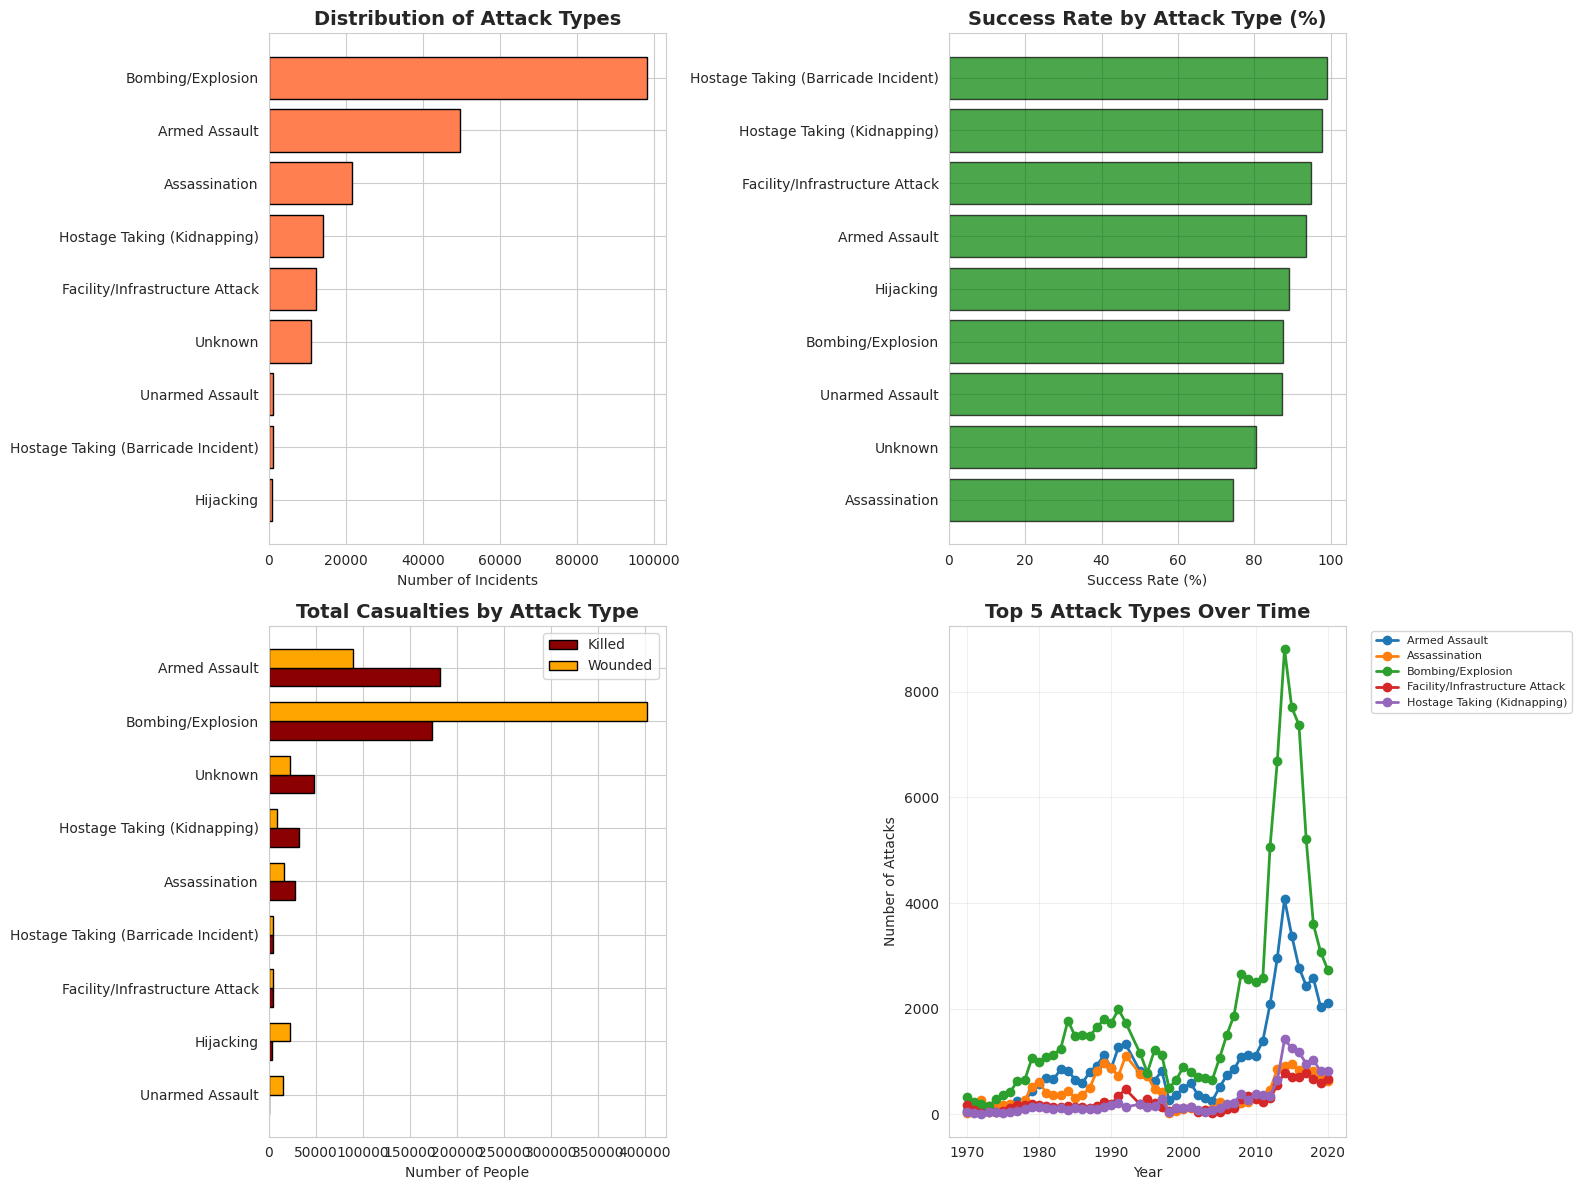

Attack type analysis completed and visualized

Attack Type Distribution:
attacktype1_txt
Bombing/Explosion                      98158
Armed Assault                          49553
Assassination                          21539
Hostage Taking (Kidnapping)            14045
Facility/Infrastructure Attack         12325
Unknown                                10942
Unarmed Assault                         1229
Hostage Taking (Barricade Incident)     1156
Hijacking                                759
Name: count, dtype: int64

BLOCK 2C: GEOGRAPHIC HOTSPOT ANALYSIS


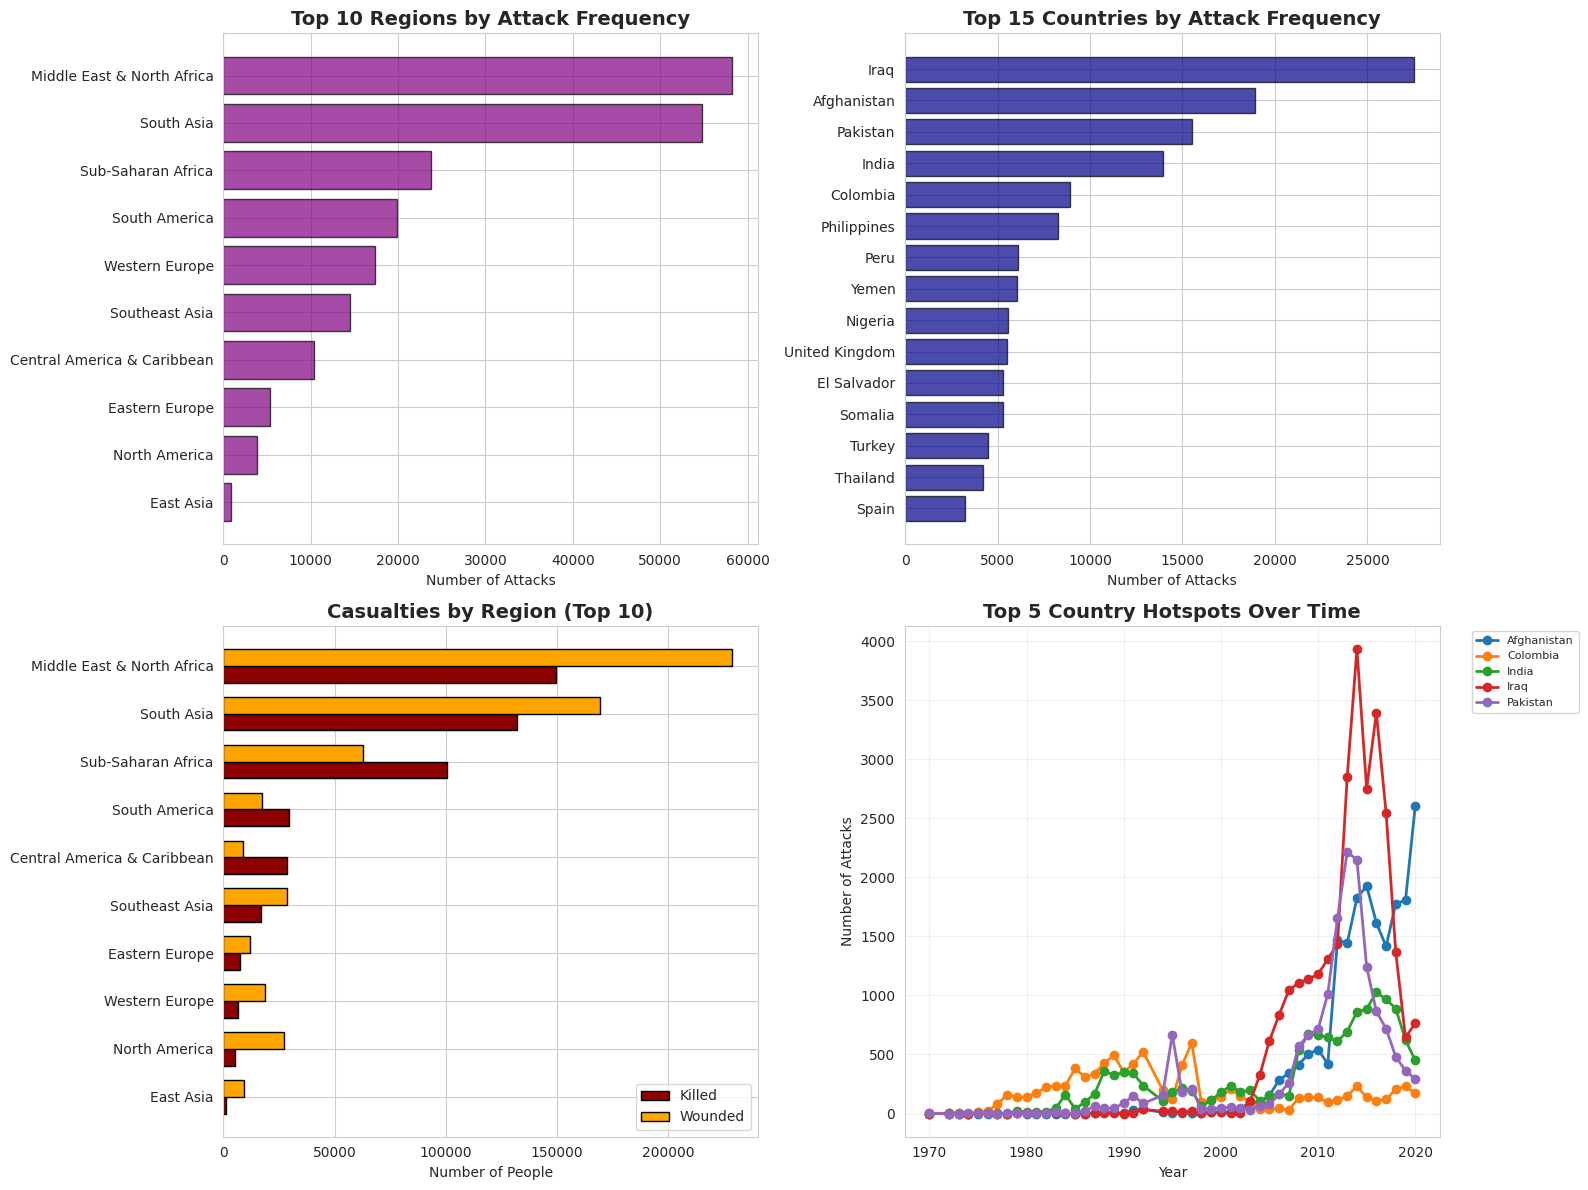

Geographic analysis completed and visualized

Top 10 Countries:
country_txt
Iraq              27521
Afghanistan       18920
Pakistan          15504
India             13929
Colombia           8915
Philippines        8271
Peru               6111
Yemen              6027
Nigeria            5550
United Kingdom     5513
Name: count, dtype: int64

BLOCK 2D: CORRELATION ANALYSIS


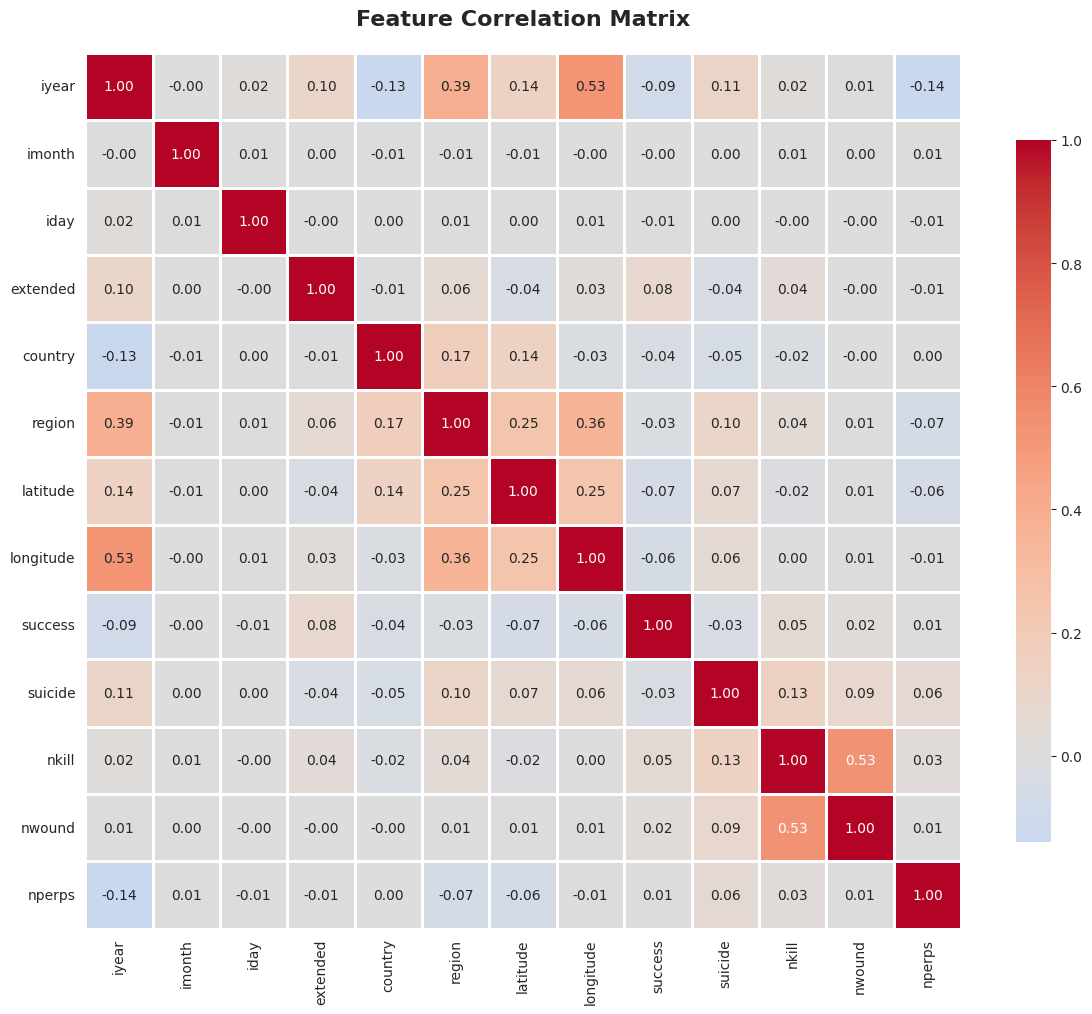

Correlation analysis completed and visualized

BLOCK 2E: TARGET CLASS BALANCE ANALYSIS


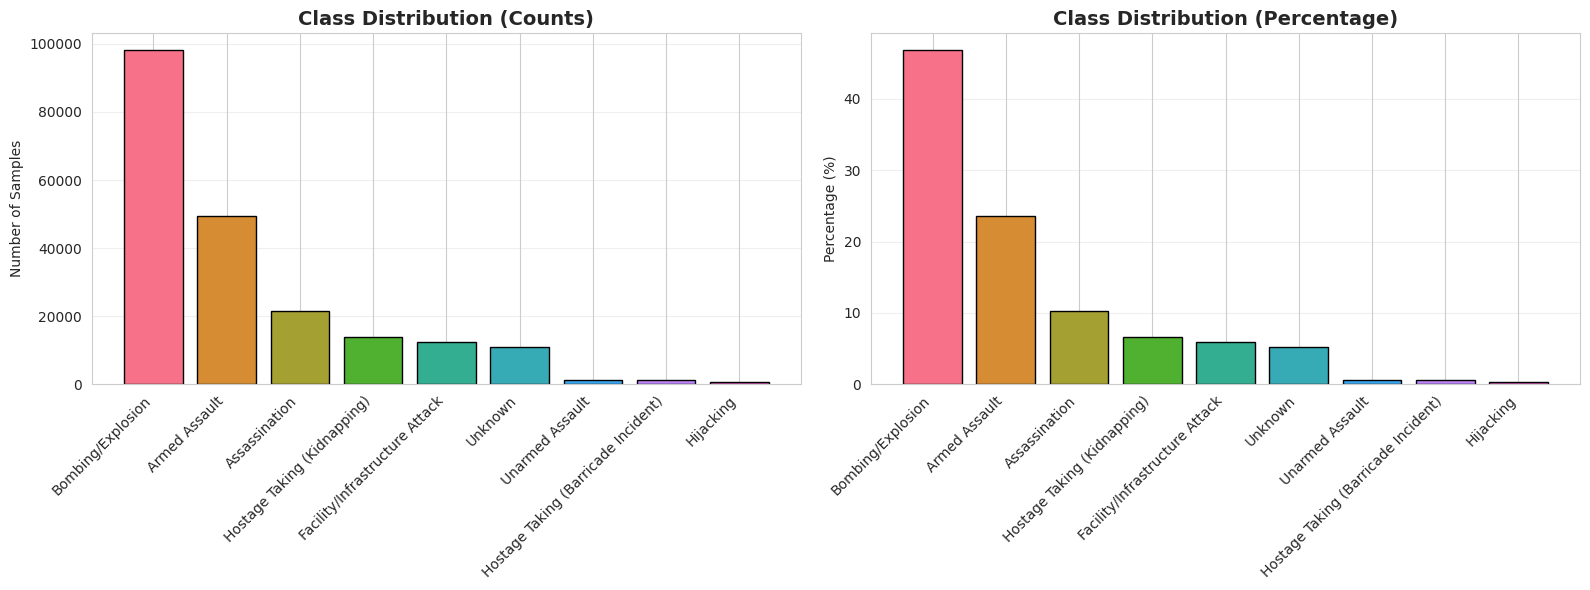

Class balance analysis completed

Class Distribution:
                                     Count  Percentage
attacktype1_txt                                       
Bombing/Explosion                    98158   46.807435
Armed Assault                        49553   23.629748
Assassination                        21539   10.271046
Hostage Taking (Kidnapping)          14045    6.697472
Facility/Infrastructure Attack       12325    5.877276
Unknown                              10942    5.217781
Unarmed Assault                       1229    0.586059
Hostage Taking (Barricade Incident)   1156    0.551248
Hijacking                              759    0.361935

Imbalance Ratio: 129.33:1 (Max class / Min class)
-> Severe imbalance detected! SMOTE recommended.

EDA PHASE COMPLETED SUCCESSFULLY!

 -> Generated visualizations:
   - eda_temporal_analysis.png
   - eda_attack_type_analysis.png
   - eda_geographic_analysis.png
   - eda_correlation_matrix.png
   - eda_class_balance.png


In [ ]:
if __name__ == "__main__":
    # Load your data
    filepath = filepath
    df = load_gtd_data(filepath)

    if df is not None:
        # Initial profiling
        missing_report = initial_data_profile(df)

        # Run all EDA modules
        eda_temporal_analysis(df)
        eda_attack_type_analysis(df)
        eda_geographic_analysis(df)

        # Define features for correlation
        features = ['iyear', 'imonth', 'iday', 'extended', 'country',
                   'region', 'latitude', 'longitude', 'success',
                   'suicide', 'nkill', 'nwound', 'nperps']

        eda_correlation_analysis(df, features)
        eda_target_class_balance(df, 'attacktype1_txt')

        print("\n" + "="*80)
        print("EDA PHASE COMPLETED SUCCESSFULLY!")
        print("="*80)
        print("\n -> Generated visualizations:")
        print("   - eda_temporal_analysis.png")
        print("   - eda_attack_type_analysis.png")
        print("   - eda_geographic_analysis.png")
        print("   - eda_correlation_matrix.png")
        print("   - eda_class_balance.png")